In [29]:
import datetime as dt  
import pandas as pd
import numpy as np
from netCDF4 import Dataset 
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Path, PathPatch # for making ocean white
import cartopy.crs as ccrs
from ncdump import ncdump
import gdal
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from VPRM_params import NLCD_def, bbox
from VPRMout_fun import Read_VPRMout,latlon_to_EPSG32618,find_a_point_in_grids,get_first_dimension_ave

FigDir = '/home/dwei/manuscripts/VPRM-sensitivity/fig/'
VPRMoutDir = '/data0/dwei/VPRMout/'

# Load NLCD and ISA
DataDir = '/data0/dwei/VPRMdata/'  # input dir
ds_nlcd = gdal.Open(DataDir+'nlcd_epsg32618_cropped.tif')
ds_ipsa = gdal.Open(DataDir+'ipsa_epsg32618_cropped.tif')
NLCD_2D = ds_nlcd.GetRasterBand(1).ReadAsArray()
IPSA_2D = ds_ipsa.GetRasterBand(1).ReadAsArray()
NLCD    = NLCD_2D.reshape(np.size(NLCD_2D))
IPSA    = IPSA_2D.reshape(np.size(IPSA_2D))
IPSA[IPSA==127] = 0.0  # 127 is the background value; assuming its zero
IPSA    = IPSA/100.0
# NLCD has zeros in the southeast corner; set them to 11 as water
NLCD[NLCD==0] = 11    
NLCD_2D[NLCD_2D==0] = 11  
water_boo = NLCD_2D==11

# Load raw EVI for UHI sensitivity analysis
dt_EVI_str = ['20210107', '20210115', '20210123', \
          '20210208','20210224',\
          '20210304','20210312','20210320',\
          '20210405', '20210413', '20210421',\
          '20210507','20210515','20210523',\
          '20210608','20210616','20210624',\
          '20210710', '20210718','20210726',\
          '20210811','20210819','20210827', \
          '20210904','20210912', '20210920', '20210928',\
          '20211006', '20211014', '20211022', '20211030',\
          '20211107','20211115','20211123', \
          '20211201','20211209','20211217']
dt_EVI = [dt.datetime.strptime(x, '%Y%m%d') for x in dt_EVI_str]
EVI_raw = pd.read_csv('/data0/dwei/Landsat/2021/EVI_all_raw')
EVI     = EVI_raw.iloc[:,1:].to_numpy()  # First column is the row index
EVI_may = EVI[:,13].reshape(np.shape(NLCD_2D))
EVI_jun1 = EVI[:,14].reshape(np.shape(NLCD_2D))
EVI_jun2 = EVI[:,15].reshape(np.shape(NLCD_2D))
EVI_jun3 = EVI[:,16].reshape(np.shape(NLCD_2D))
EVI_jul = EVI[:,17].reshape(np.shape(NLCD_2D))

# WRF domain averages
# WRF Mean  0.6411057 0.3110174 0.12896805
# WRF STD   0.49704304 0.25559992 0.31786233


In [2]:
##########################################################
#                                                        #
#                   Trees or no trees                    #
#                                                        #
##########################################################
# Load NetCDF files
# One-month simulation (202106)
filepath_grs = VPRMoutDir+'GRS_June_20220322.nc'    
filepath_dbf = VPRMoutDir+'DBF_June_20220322.nc' 
filepath_isa = VPRMoutDir+'ISA_June_20220322.nc' 

GEE_grs, Resh_grs, Resa_grs, NEE_grs, time_grs, Xdim_grs, Ydim_grs, TMP_grs = \
                                                        Read_VPRMout(filepath_grs)
# GEE_dbf, Resh_dbf, Resa_dbf, NEE_dbf, time_dbf, Xdim_dbf, Ydim_dbf, TMP_dbf = \
#                                                         Read_VPRMout(filepath_dbf)
# GEE_isa, Resh_isa, Resa_isa, NEE_isa, time_isa, Xdim_isa, Ydim_isa, TMP_isa = \
#                                                         Read_VPRMout(filepath_isa)

# Set water to nan 
NEE_grs[:, water_boo] = np.nan
# NEE_dbf[:, water_boo] = np.nan
# NEE_isa[:, water_boo] = np.nan

GEE_grs[:, water_boo] = np.nan
# GEE_dbf[:, water_boo] = np.nan
# GEE_isa[:, water_boo] = np.nan

Resh_grs[:, water_boo] = np.nan
# Resh_dbf[:, water_boo] = np.nan
# Resh_isa[:, water_boo] = np.nan

Resa_grs[:, water_boo] = np.nan
# Resa_dbf[:, water_boo] = np.nan
# Resa_isa[:, water_boo] = np.nan

# Total RES
Res_grs = Resa_grs+Resh_grs
# Res_isa = Resa_isa+Resh_isa
# Res_dbf = Resa_dbf+Resh_dbf

DT = np.array([dt.datetime.fromtimestamp(t) for t in time_grs])
Hours = np.array([ddt.hour for ddt in DT])


In [3]:
# grassland type (land cover number 71)
def get_lc_NEE_diurnal(lc, NEE):
    boo_lc_grs = NLCD_2D==lc
    NEE_hr_ave = []
    NEE_hr_std = []
    for hr in range(0, 24):
        #print('Hour', hr)
        boo_hr = Hours==hr
        NEE_hr = NEE[boo_hr,:]
        NEE_hr_grs_ave = NEE_hr[:, boo_lc_grs]

        NEE_tmp = []
        for day in range(0,30):
            NEE_tmp.append(np.nanmean(NEE_hr_grs_ave[day, :]))
        NEE_hr_ave.append(np.nanmean(NEE_tmp))
        NEE_hr_std.append(np.nanstd(NEE_tmp))  
    return NEE_hr_ave,NEE_hr_std

NEE_deo_ave,NEE_deo_std = get_lc_NEE_diurnal(21, NEE_grs) # open space averages
NEE_grs_ave,NEE_grs_std = get_lc_NEE_diurnal(71, NEE_grs) # grassland averages

plt.figure()
plt.errorbar(range(0, 24), NEE_grs_ave, NEE_grs_std, label='all grass')
plt.errorbar(range(0, 24), NEE_deo_ave, NEE_deo_std, label='Open space')
plt.legend()
plt.ylabel('Res')
plt.xlabel('Time of day')


In [49]:
# a single point
ML1=[40.865471, -73.8796194]       
ML2=[40.8656782,-73.8796089]   # ML2
UL1=[40.8568287,-73.8784399]   # UL1
UL2=[40.8569182,-73.8783162]   # UL2
HL1=[40.8676297,-73.8780359]
HL2=[40.86763105,-73.8780495]
HL3=[40.865305,-73.8833816]    # HL3
HL4=[40.8652045,-73.8835081]
x,y = latlon_to_EPSG32618(HL2)
collar_str='HL2'
x_ind,y_ind = find_a_point_in_grids(x, y, Xdim_grs, Ydim_grs)
print(NLCD_2D[x_ind, y_ind])


[24]


[array([0.06]), array([nan]), array([0.0383]), array([nan]), array([nan])]


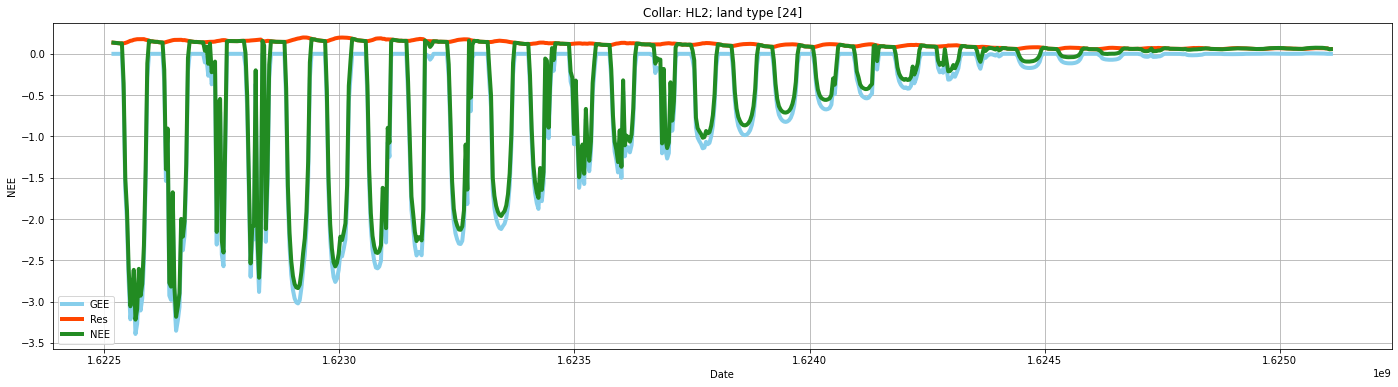

In [56]:
EVI_ts = [EVI_may[x_ind,y_ind], EVI_jun1[x_ind,y_ind],EVI_jun2[x_ind,y_ind],\
          EVI_jun3[x_ind,y_ind],EVI_jul[x_ind,y_ind]]

NEE_loc = NEE_grs[:, x_ind, y_ind].flatten()
GEE_loc = GEE_grs[:, x_ind, y_ind].flatten()
Res_loc = Res_grs[:, x_ind, y_ind].flatten()

fig = plt.figure(figsize=(24,6))
FontSize = 10
LineWidth =4
row = 1
col = 1

ax = fig.add_subplot(row, col, 1)
ax.set_title('Collar: '+ collar_str+ '; land type ' + str(NLCD_2D[x_ind, y_ind]))
ax.plot(time_grs, GEE_loc, color='skyblue', linewidth=LineWidth, label='GEE')
ax.plot(time_grs, Res_loc, color='orangered', linewidth=LineWidth, label='Res')
ax.plot(time_grs, NEE_loc, color='forestgreen', linewidth=LineWidth, label='NEE')
# ax.set_xticks(range(0, 24, 4))
ax.set_ylabel('NEE', fontsize = FontSize)
ax.set_xlabel('Date', fontsize = FontSize)
ax.grid()
# ax.set_xlim(dt.date(2021, 6, 1), dt.date(2021, 7, 1))
ax.legend()

# ax = fig.add_subplot(row, col, 2)
# ax.set_title('EVI over the period')
# ax.plot(range(0, 5), EVI_ts, color='skyblue', linewidth=LineWidth, label='EVI')
print(EVI_ts)
